In [54]:
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import math

# Accumulator Models

Accumulator models are designed to account for decision-making. The typical paradigm they are applied for is the motion coherence detecion task:

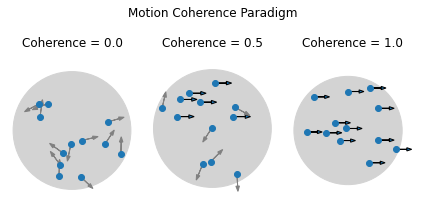

In [129]:
fig, axs = plt.subplots(1, 3, figsize = (6, 3))

points = [[x/10.0, y/10.0] for x in range(10) for y in range(10)]
points = [x for x in points if np.sqrt((x[0]-0.5)**2 + (x[1] - 0.5)**2) < 0.45]

npoints = 12
for i, coh in enumerate((0, 0.5, 1)):
    ax = axs[i]
    circle = plt.Circle((0.5,0.5), 0.5, color='lightgrey')
    ax.add_patch(circle)
    ax.axis('off')
    ax.axis('equal')
    
    # generate dots
    sub = rnd.sample(points, k = npoints)
    
    # jitter
    for p in sub:
        p[0] += rnd.uniform(-0.03, 0.03)
        p[1] += rnd.uniform(-0.03, 0.03)
        
    ax.plot([x[0] for x in sub], [x[1] for x in sub], 'o')
    n = int(npoints * coh)
    move = sub[0:n]
    non_move = sub[n:]
    
    for p in move:
        ax.arrow(p[0], p[1], 0.1, 0, head_width=0.03)
        
    for p in non_move:
        angle = rnd.uniform(0, 2*math.pi)
        dx = math.cos(angle) * 0.1
        dy = math.sin(angle) * 0.1
        ax.arrow(p[0], p[1], dx, dy, head_width=0.03, color='grey')
        
    ax.set_title("Coherence = %.1f" % (coh,))
    
fig.suptitle("Motion Coherence Paradigm")
fig.tight_layout()
#fig.savefig("figures/motion_coherence.png", dpi=200)
plt.show()

## Ratcliff's Drift Diffusion Model

Here is a Python class that embeds a DDM.

In [159]:
class DDM():
    """A simple implementation of Ratcliff's Drift Diffusion Model"""
    
    def __init__(self, v = 0.6, a = 1, ter = 0.2, z = 0, sdv = 0.0):
        """Initializes the model"""
        self.xstep = 0.05 
        self.ystep = 0.05
        self.v = v
        self.a = a
        self.z = z
        self.sdv = sdv
        self.start = a/2 + z
        self.ter = ter
    
    def trial(self):
        """Simulates one decision"""
        x = self.ter
        y = self.start
        trace = [[x, y]]
        this_v = self.v
        if self.sdv > 0:
            this_v = rnd.gauss(self.v, self.sdv)
        while y > 0 and y < self.a:
            if rnd.uniform(0, 1) < this_v:
                y += self.ystep    
            else:
                y -= self.ystep
            x += self.xstep
                
            trace.append([x, y])
        return trace
    
    def run(self, n=100):
        """Runs N simulated trials and returns the corresponding diffusion traces"""
        traces = []
        
        for i in range(n):
            traces.append(self.trial())
        
        return traces
    

Here is an example of a DDM in action. As it is common, the top part presents an hystogram of the distribution of the response times for correct (blue) and incorrect (orange) responses across all the (simulated) trials, while the bottom plot illustrates $k$ example diffusion traces.

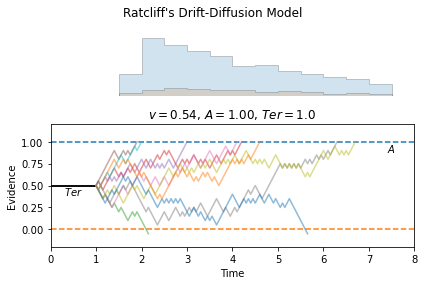

In [161]:
d = DDM(z=0., v = 0.54, ter=1.0, a= 1.0)
traces = d.run(10000)

times_a = [x[-1][0] for x in traces if x[-1][1] > d.a]
times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

axs1.get_xaxis().set_visible(False)
axs1.get_yaxis().set_visible(False)
axs1.axis('off')

axs2.set_ylim(-0.2, 1.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, d.ter], [d.start, d.start], "k")
axs2.plot([0, max_time], [d.a, d.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, d.ter], [d.start, d.start], "k")

axs2.text(s=r"$Ter$", x=d.ter/2, y = d.start, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = d.a, ha='center', va = 'top')

subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k=10)

for trace in subset:
    data = np.array(trace)
    axs2.plot(data[:,0], data[:,1], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (d.v, d.a, d.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist((times_a, times_0), **kwargs)

fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.savefig("figures/ddm.png", dpi=200)
plt.show()

### Speed-Accuracy Trade-Off

The speed-accuracy trade-off can be modeled by adjusting the decision boundary $A$.

(8903, 1097)
(8205, 1795)


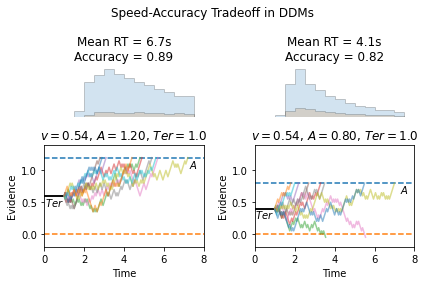

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

for i, a in enumerate((1.2, 0.8)):
    model = DDM(z = 0., v = 0.54, ter = 1.0, a = a) 
    traces = model.run(10000)
    times_a = [x[-1][0] for x in traces if x[-1][1] > model.a]
    times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]
    print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.2, 1.4)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.start, model.start], "k")
    ax2.plot([0, max_time], [model.a, model.a], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.start, model.start], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.start, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.a, ha = 'center', va = 'top')

    subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k = 10)

    for trace in subset:
        data = np.array(trace)
        ax2.plot(data[:,0], data[:,1], alpha=0.5)

    # stats:
    mean_rt = np.mean(times_a)
    mean_acc = len(times_a)/10000
    bins = [x/2 for x in range(0, 2*max_time)]
    ax1.set_title("Mean RT = %.1fs\nAccuracy = %.2f" % (mean_rt, mean_acc)) 
    ax2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (model.v, model.a, model.ter)) 
    kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
    ax1.hist((times_a, times_0), **kwargs)
    
fig.suptitle("Speed-Accuracy Tradeoff in DDMs")
fig.tight_layout()
plt.savefig("figures/speed_accuracy_tradeoff.png", dpi=200)
plt.show()


### Response Bias $z$

Sometimes one option is intrinsically favored. This can be, for example, for innate response preferences (e.g., hand dominance), for prior knowledge (e.g., cued response direction), or for reward incentives (higher payoff to get it right). All of these circumstances can be modeled by adding one parameter that shifts the starting position of the trace.

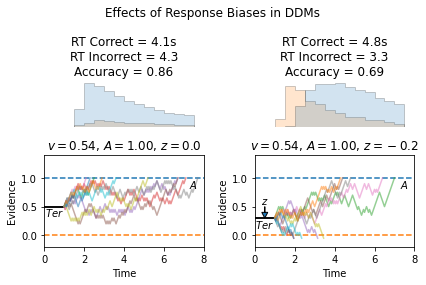

In [123]:
fig, axes = plt.subplots(2, 2, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

for i, z in enumerate((0, -0.2)):
    model = DDM(z = z, v = 0.54, ter = 1.0, a = 1.0) 
    traces = model.run(10000)
    times_a = [x[-1][0] for x in traces if x[-1][1] > model.a]
    times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]
    #print((len(times_a), len(times_0)))
    ax1, ax2 = axes[:,i]
    ax1.set_xlim(0, max_time)
    ax2.set_xlim(0, max_time)

    ax1.get_xaxis().set_visible(False)
    ax1.get_yaxis().set_visible(False)
    ax1.axis('off')
    
    ax2.set_ylim(-0.2, 1.4)
    ax2.set_ylabel("Evidence")
    ax2.set_xlabel("Time")

    # The traces

    ax2.plot([0, model.ter], [model.start, model.start], "k")
    ax2.plot([0, max_time], [model.a, model.a], '--')
    ax2.plot([0, max_time], [0, 0], '--')
    ax2.plot([0, model.ter], [model.start, model.start], "k")

    ax2.text(s=r"$Ter$", x = model.ter/2, y = model.start, ha = 'center', va = 'top')
    ax2.text(s=r"$A$", x = max_time - 0.5, y = model.a, ha = 'center', va = 'top')
    
    if model.z != 0:
        ax2.arrow(model.ter/2, model.a/2, 0, model.z, head_length = abs(model.z)/2, head_width=0.3, length_includes_head=True)
        ax2.text(s=r"$z$", x = model.ter/2, y = model.a/2, ha = 'center', va = 'bottom')

    subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k = 10)

    for trace in subset:
        data = np.array(trace)
        ax2.plot(data[:,0], data[:,1], alpha=0.5)

    # stats:
    rt_correct = np.mean([x for x in times_a if x < 8])
    rt_incorrect = np.mean([x for x in times_0 if x < 8])
    mean_acc = len(times_a)/10000
    bins = [x/2 for x in range(0, 2*max_time)]
    ax1.set_title("RT Correct = %.1fs\nRT Incorrect = %.1f\nAccuracy = %.2f" % (rt_correct, rt_incorrect, mean_acc)) 
    ax2.set_title(r"$v = %.2f$, $A = %.2f$, $z = %.1f$" % (model.v, model.a, model.z)) 
    kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
    ax1.hist((times_a, times_0), **kwargs)
    
fig.suptitle("Effects of Response Biases in DDMs")
fig.tight_layout()
plt.savefig("figures/response_biases.png", dpi=200)
plt.show()


### Modeling errors

It is done by adding inter-trial variability.

3530
6470


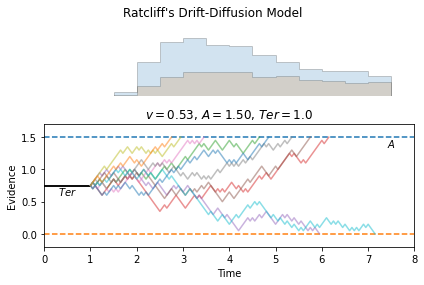

In [166]:
#fig, (axs1, axs2, axs3) = plt.subplots(3, 1, figsize=(5,5), gridspec_kw={'height_ratios': [1, 2, 1]})

d = DDM(z=0., v = 0.53, ter=1.0, a= 1.5, sdv=0.075)
traces = d.run(10000)

times_a = [x[-1][0] for x in traces if x[-1][1] > d.a]
times_0 = [x[-1][0] for x in traces if x[-1][1] < 0]

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)
#axs3.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')
    #ax.set_ylim(0, 2000)
    #axs3.set_ylim(0, 10)

axs2.set_ylim(-0.2, d.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

#axs3.invert_yaxis()

# The traces

axs2.plot([0, d.ter], [d.start, d.start], "k")
axs2.plot([0, max_time], [d.a, d.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, d.ter], [d.start, d.start], "k")

axs2.text(s=r"$Ter$", x=d.ter/2, y = d.start, ha='center', va = 'top')
axs2.text(s=r"$A$", x=max_time - 0.5, y = d.a, ha='center', va = 'top')
#axs2.text(s=r"$0$", x=max_time - 0.5, y = 0, ha='center', va = 'bottom')

subset = rnd.choices([x for x in traces if x[-1][0] < max_time], k=10)

for trace in subset:
    data = np.array(trace)
    axs2.plot(data[:,0], data[:,1], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (d.v, d.a, d.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist((times_a, times_0), **kwargs)
fig.suptitle("Ratcliff's Drift-Diffusion Model")
fig.tight_layout()
plt.show()


## Race Models

Race models have only one boundary.

### The Linear Ballistic Accumulator model 

The LBA is a random-ray model. The drift rate is the angle at which the ray is movinbg towards the boundary. Inter-trial variability comes from teh angle being drawn from a normal distribution.

In [193]:
class LBA:
    """Brown and Heathcote's Linear Ballistic Accumulator""" 
    def __init__(self, v, a, ter, vsd=0.1):
        """Initializes the main parameters"""
        self.v = v
        self.a = a
        self.ter = ter
        self.vsd = vsd
        
    def trial(self):
        """Simulates a single trial as a random ray"""
        angle = min(math.pi/4, max(1.0e-6, rnd.gauss(self.v, self.vsd)))
        ray_length = self.a / np.sin(angle)
        t = self.a / np.tan(angle)
        return (t + self.ter, self.a)
    
    def run(self, n = 1000):
        """Simulates N trials"""
        traces = []
        for i in range(n):
            traces.append(self.trial())
            
        return traces

Here is an illustration of the LBA in action

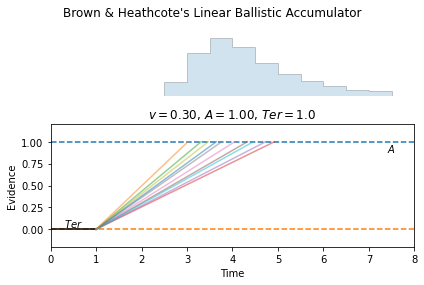

In [194]:
lba = LBA(v = 0.3, a = 1, ter=1)

traces = lba.run(10000)

fig, (axs1, axs2) = plt.subplots(2, 1, figsize=(6,4), gridspec_kw={'height_ratios': [1, 2]})

max_time = 8

axs1.set_xlim(0, max_time)
axs2.set_xlim(0, max_time)

for ax in (axs1,):#, axs3):
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.axis('off')

axs2.set_ylim(-0.2, lba.a + 0.2)
axs2.set_ylabel("Evidence")
axs2.set_xlabel("Time")

# The traces

axs2.plot([0, max_time], [lba.a, lba.a], '--')
axs2.plot([0, max_time], [0, 0], '--')
axs2.plot([0, d.ter], [0, 0], "k")

axs2.text(s=r"$Ter$", x=lba.ter/2, y = 0, ha='center', va = 'bottom')
axs2.text(s=r"$A$", x=max_time - 0.5, y = lba.a, ha='center', va = 'top')

subset = rnd.sample([x for x in traces if x[0] < max_time], k = 10)

for trace in subset:
    axs2.plot([lba.ter, trace[0]], [0, trace[1]], alpha=0.5)

bins = [x/2 for x in range(0, 2*max_time)]
axs2.set_title(r"$v = %.2f$, $A = %.2f$, $Ter = %.1f$" % (lba.v, lba.a, lba.ter)) 
kwargs = dict(histtype='stepfilled', alpha=0.2, density=False, bins=bins, ec="k")
axs1.hist([t[0] for t in traces], **kwargs)
#axs3.hist((times_a, times_0), **kwargs)
fig.suptitle("Brown & Heathcote's Linear Ballistic Accumulator")
fig.tight_layout()
plt.savefig("figures/lba.png", dpi=200)
plt.show()
